How to estimate noise in High-Frequency radar radial measurements
===================

This tutuorial shows how to estimate noise from High-Freuency data. It reproduces the calculations and figures of the paper:

* Jordi Isern-Fontanet, Lucía Quirós-Collazos, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Pedro Agostinho, Cristina González-Haro and Emili García-Ladona (2026). **Data-Driven Noise Estimation for Individual High-Frequency Radar Stations**. Submitted to *J. Atmos. Oceanic Technol.*

This turtorial uses the dataset:

* Lucía Quirós-Collazos, Jordi Isern-Fontanet, Jordi Iglesias, Justino. Martínez, Joaquim Ballabrera-Poy, Jaume García-Theatre, Cristina González-Haro and Emili García-Ladona (2025). **Radial velocities for noise estimation of ICATMAR HF radar stations (v1.0)** https://doi.org/10.20350/digitalCSIC/17704

In [1]:
# System modules

import os
import glob
import sys

# Import scientific modules

import numpy as np
import xarray as xr

# Graphical packages

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, COLORS

# Import the toosl for estimating noise

# Add the path to the package if it is not already in PYTHONPATH

sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1]) + os.sep)
from hfradar import hfr_noise, lmercator, hfr_rmse_pairs, hfr_rmse_model, hfr_rmse_fit

# Each time a module is modified it is releaded

%load_ext autoreload
%autoreload 2

# Inline ploting

%matplotlib inline

# Parameters

Set the parameters necessary to run the notebook. Download the data set from https://doi.org/10.20350/digitalCSIC/17704 and modify `datapath` accordingly.

In [2]:
datapath = '/Users/jisern/Recerca/Data/Radar/L2B/'
figspath = 'figures'

Physical parameters

In [3]:
nmin = 10              # Minimum number of points to be used in computing RMSE
rmin = 0               # Minimum range used in computing RMSE [km]
rmax = 100             # Maximum range used in computing RMSE [km]
maxdist = 500          # Maximum distance used to identify pairs [m]
example_stat = 'GNST'  # Station used for examples
iexample = 10          # Index of the day used as an example

# Define the twio sub-networks

networks = [['CREU', 'BEGU'], ['AREN', 'PBCN', 'GNST']]

Graphical parmeters

In [4]:
width = 4
height = 3

Graphical information and objects

In [5]:
# Default color cycle

refcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Land mask for maps

land = NaturalEarthFeature(category='physical',
                           name='land',
                           scale='10m',
                           facecolor=COLORS['land'])
# Ocean mask for maps

ocean = NaturalEarthFeature(category='physical',
                            name='ocean',
                            scale='10m',
                            facecolor=COLORS['water'])

# Load and prepare the data

Load the data

In [6]:
hfrdata = {}              # Radar data

print('Loading data:')

for file in glob.glob(datapath + 'RDLm_????_*l2b.nc'):

    # Get the station name

    print('--', file)

    # Read the data

    ds = xr.open_dataset(file, engine="netcdf4")

    # Get information about the stations

    site = ds.attrs['Site'][:4]

    res = ds.attrs['Origin'].split(' ')
    lat0 = float(res[0])
    lon0 = float(res[-1])
    
    # Input files only has lat/lon when there were measurents. Extract all possible lat/lon. Data
    # gaps contain nan

    lon = ds['lon'].mean(dim='time')
    lat = ds['lat'].mean(dim='time')

    # Remove unused variables and those that will be modifued (lat/lon)

    ds = ds.drop_vars(['lon', 'lat', 'Q201', 'Q202', 'Q203', 'Q204', 'Q205', 'Q206', 'Q207', 
                       'VELU', 'VELV', 'VFLG', 'SPRC', 'HEAD', 'ETMP', 'ESPC', 'ERTC', 
                       'ERSC', 'EDTP', 'EASN', 'MAXV', 'MINV', 'XDST', 'YDST'])

    # Substitute lat/lon in the dataset by the new values

    ds.coords['lon'] = lon
    ds.coords['lat'] = lat

    # Number of observations at each range/bearing using the Primary Flag ('PRIM').

    count = xr.zeros_like(ds['PRIM'], dtype=int)
    count.data[ds['PRIM'].data == 1] = 1
    ds['nobs'] = count
    ds['nobs'].attrs["long_name"] = 'Number of observations'

    # Update attributes

    ds.attrs['Input_file'] = file
    ds.attrs['Site'] = site
    ds.attrs['lon0'] = lon0
    ds.attrs['lat0'] = lat0
    
    # Save the data

    hfrdata.update({site:ds})
    
print('Done')

Loading data:
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_PBCN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_AREN_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_GNST_20231201_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_CREU_20230501_20250529_l2b.nc
-- /Users/jisern/Recerca/Data/Radar/L2B/RDLm_BEGU_20230401_20250529_l2b.nc
Done


Compute distances

In [7]:
# Get the mean lat/lon

lon0 = []
lat0 = []
for site in hfrdata:
    lon0.append(hfrdata[site].attrs['lon0'])
    lat0.append(hfrdata[site].attrs['lat0'])
lon0 = np.mean(lon0)
lat0 = np.mean(lat0)

# Mercator projection of positions

for site in hfrdata:
    lon = hfrdata[site]['lon']
    lat = hfrdata[site]['lat']
    x, y = lmercator(lon, lat, lon0=lon0, lat0=lat0)
    hfrdata[site].coords['x'] = x * 1e-3
    hfrdata[site].coords['y'] = y * 1e-3

Sort sites starting from the northrenmost one

In [8]:
hfrsites = []           # List of available sites sorted from North to south

# Extract the location of the station

dummy = []
for site in hfrdata.keys():
    dummy.append(hfrdata[site].attrs['lat0'])
    hfrsites.append(site)

# Convert to numpy arrays and sort

index = np.argsort(dummy)[::-1]
hfrsites = np.array(hfrsites)[index]

Assign colors to each site

In [9]:
hfrcolors = {}           # Colors for each HFR station

for i, site in enumerate(hfrsites):
    hfrcolors.update({site: refcolors[i]})

# Estimate noise

Compute noise using the k-sigma clipping method. Daily average to reduce the size and number of data gaps.

In [10]:
hfrdata_daily = {}

print('Computing noise:')
for site in hfrsites:
    
    print('--', site)

    # Daily averages
    
    hfrdata_daily.update({site: hfrdata[site].resample(time='1D').mean()})

    hfrdata_daily[site]['nobs'] = hfrdata[site]['nobs'].resample(time='1D').sum()
    hfrdata_daily[site]['nobs'].attrs["long_name"] = 'Number of observations'
    hfrdata_daily[site]['nobs'].attrs["units"] = 'n/a'    
    
    # Compute noise
    
    nobs = hfrdata_daily[site]['nobs'].data
    nobs[np.logical_not(np.isfinite(nobs))] = 0
    nobs = nobs.astype(int)

    ur = hfrdata_daily[site]['VELO'].data
    ur = np.ma.array(data=ur, mask=nobs <  1)
    
    sigma, w1 = hfr_noise(ur, nobs=nobs, return_coeff=True)

    # Add to the corresponding dataset

    hfrdata_daily[site]['w1'] = xr.zeros_like(hfrdata_daily[site]['VELO'])
    hfrdata_daily[site]['w1'].data = w1
    hfrdata_daily[site]['w1'].attrs["long_name"] = 'Wavelet coefficents at teh firs scale labeled as noise'
    hfrdata_daily[site]['w1'].attrs["units"] = 'cm/s'

    hfrdata_daily[site]['sigma'] = xr.DataArray(sigma, dims=('time',))
    hfrdata_daily[site]['sigma'].attrs["long_name"] = 'Standard deviation of noise'
    hfrdata_daily[site]['sigma'].attrs["units"] = 'cm/s'

print('Done')

Computing noise:
-- CREU
-- BEGU
-- AREN
-- PBCN
-- GNST
Done


Generate a table with the results

In [11]:
for site in hfrsites:

    ur = hfrdata[site]['VELO'].data
    index = np.isfinite(ur)
    mean_ur = np.sqrt(np.mean(ur[index] ** 2))
    
    sigma = hfrdata_daily[site]['sigma'].data
    index = np.isfinite(sigma)
    mean_noise = np.mean(sigma[index])
    std_noise = np.std(sigma[index])
    
    formatstr = "{:} & {:2.1f} & {:.1f} $\\pm$ {:.1f} & {:.1f} $\\pm$ {:.1f} \\\\"
    print(formatstr.format(site,
                           mean_ur,
                           mean_noise, 
                           std_noise, 
                           mean_noise * np.sqrt(24), 
                           std_noise * np.sqrt(24)))

CREU & 24.3 & 2.9 $\pm$ 0.5 & 14.1 $\pm$ 2.7 \\
BEGU & 22.7 & 2.1 $\pm$ 0.3 & 10.1 $\pm$ 1.4 \\
AREN & 15.9 & 1.8 $\pm$ 0.2 & 8.7 $\pm$ 1.1 \\
PBCN & 17.7 & 1.6 $\pm$ 0.2 & 7.6 $\pm$ 1.2 \\
GNST & 20.0 & 1.9 $\pm$ 0.3 & 9.2 $\pm$ 1.3 \\


Estimate noise using the method described by Kim et al.

In [12]:
hfrnetworks = {}

for netwk in networks:

    name = '-'.join(netwk)
    
    # Compute the RMSE from all possible pairs of stations

    rmse = np.zeros(0)
    angle = np.zeros(0)
    
    i, j = np.triu_indices(len(netwk), k=1)
    for site1, site2 in zip(np.array(netwk)[i],np.array(netwk)[j]):
        res = hfr_rmse_pairs(hfrdata[site1], hfrdata[site2], 
                             maxdist=maxdist, nmin=nmin, rmin=rmin, rmax=rmax)
        angle = np.append(angle, res[0])
        rmse = np.append(rmse, res[1])
    
    # Build the output
    
    hfrnetworks.update({name: {'angle':angle, 'rmse': rmse, 'noise': 0,
                              'rmin':rmin, 'rmax':rmax}})

    # Fit the RMSE model

    angle = np.abs(hfrnetworks[name]['angle'])
    rmse = hfrnetworks[name]['rmse']

    stdu, stde, cov = hfr_rmse_fit(angle, rmse, stdu=15, stde=8)

    hfrnetworks[name].update({'stde':stde, 'stdu':stdu})
    
    print(name, 'RMSE:',stde, 'cm/s', 'Pairs:', angle.shape[0])

print('Done')

CREU-BEGU RMSE: 13.16091534602544 cm/s Pairs: 188
AREN-PBCN-GNST RMSE: 9.431700020219404 cm/s Pairs: 339
Done


# Figures

Create output folder, if it does not exists

In [13]:
if not os.path.exists(figspath):
    os.mkdir(figspath)

Plot the general characteristics of the data

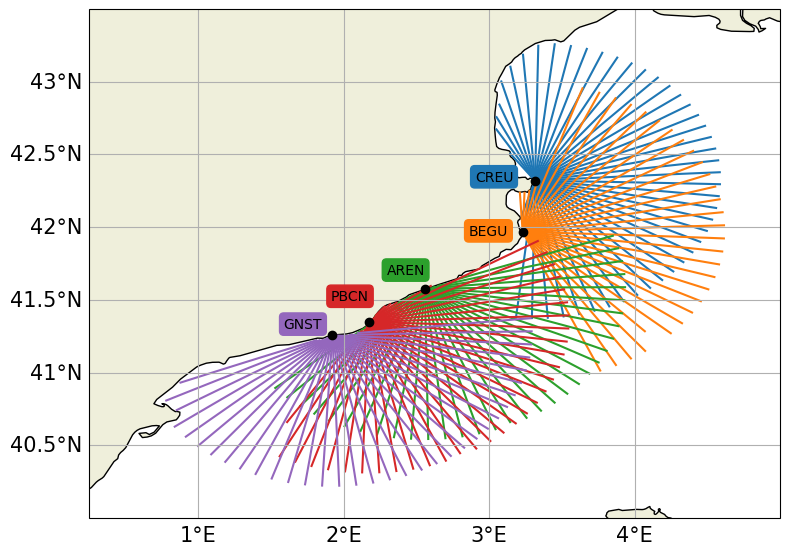

In [14]:
# Plot limits

lonmin = 5
lonmax = 0.25
latmin = 40
latmax = 43.5

# Build the plot

fig, ax = plt.subplots(figsize=(2 * width, 2 * height), 
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())

# Add the data

for site in hfrsites:

    # Get the data
    
    nr = hfrdata[site].sizes['range']
    nb = hfrdata[site].sizes['bearing']

    #ur = hfrdata[site].VELO.data
    #flag = hfrdata[site].PRIM.data
    #range = hfrdata[site].range.data
    lon = hfrdata[site].lon.data
    lat = hfrdata[site].lat.data
    nobs = hfrdata[site].nobs.sum(dim='time').astype(int)

    # Fill the map
    
    for i in np.arange(nb):
        index = nobs[:, i] > 1
        ax.plot(lon[index, i], lat[index, i], 
                color=hfrcolors[site], label=site, transform=ccrs.PlateCarree())

# Site location

for site in hfrsites:

    if site == 'CREU' :
        dlat = 0
        dlon = -0.15
    elif site == 'BEGU':
        dlat = -0.02
        dlon = -0.1
    elif site == 'AREN':
        dlat = 0.1
        dlon = 0
    elif site == 'PBCN':
        dlat = 0.15
        dlon = 0        
    elif site == 'GNST':
        dlat = 0.05
        dlon = -0.07
    else:
        dlat = 0
        dlon = 0

    lon0 = hfrdata[site].attrs['lon0']
    lat0 = hfrdata[site].attrs['lat0']
    
    ax.plot(lon0, lat0, 'ko', transform=ccrs.PlateCarree())
    ax.text(lon0 + dlon, lat0 + dlat, site, transform=ccrs.PlateCarree(), ha='right', 
            bbox={'boxstyle':'Round', 'color':hfrcolors[site]})

ax.add_feature(land, edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
gl.top_labels = False
gl.right_labels = False

fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure1.pdf')

**Figure 1**. Location of the HFR stations used in this study and available radials for each station. The triangle indicates the location of moored current-meter.

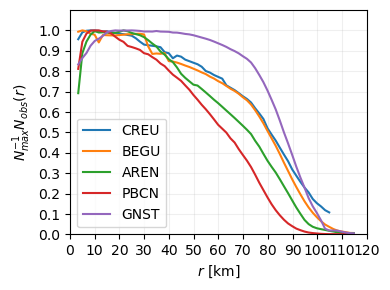

In [15]:
fig, ax = plt.subplots(figsize=(width, height))

for site in hfrsites:

    # Get the data
    
    #nr = hfrdata[site].sizes['range']
    #nb = hfrdata[site].sizes['bearing']

    #ur = hfrdata[site].VELO.data
    #flag = hfrdata[site].PRIM.data
    range = hfrdata[site].range.data
    #lon = hfrdata[site].lon.data
    #lat = hfrdata[site].lat.data
    nobs = hfrdata[site].nobs.sum(dim='time').astype(int)

    # Fill the data distribution

    n = np.sum(nobs, axis=-1)
    ax.plot(range, n / np.max(n), color=hfrcolors[site], label=site)

ax.set_xlabel('$r$ [km]')
ax.grid(True, alpha=0.2)
ax.set_xticks(np.linspace(0, 120, num=13))
ax.set_xlim(0, 120)
ax.legend()
ax.set_ylabel('$N_{max}^{-1}N_{obs}(r)$')
ax.set_yticks(np.linspace(0, 1, num=11))
ax.set_ylim(0, 1.1)

fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure2.pdf')

**Figure 2**. Dependence with distance to the antenna of the number of observations divided by its observed maximum.

2024-01-01T00:00:00.000000000


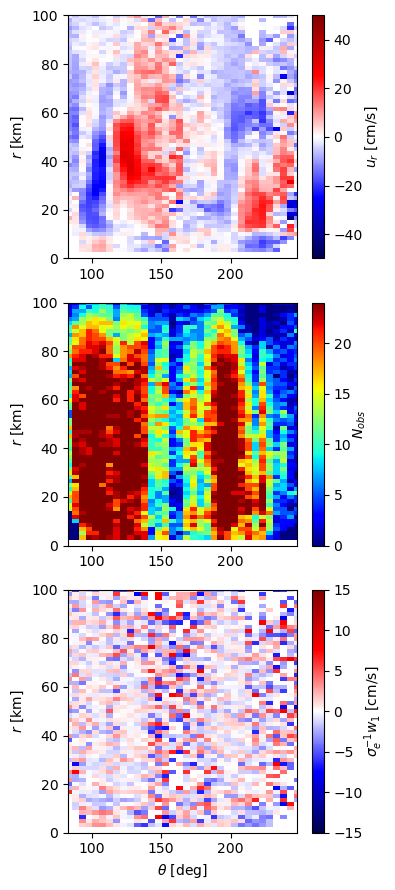

In [16]:
# Parameters

station = example_stat
orientation = 'v'
varlist = ['vel', 'num', 'w1']
i = iexample

# Prepare the data

bearing = hfrdata_daily[station]['bearing'].data
range = hfrdata_daily[station]['range'].data
time = hfrdata_daily[station]['time'][i].data
nobs = hfrdata_daily[station]['nobs'][i, :, :].data
ur = hfrdata_daily[station]['VELO'][i, :, :].data

print(time)

# Compute noise. We do not use the noise compute before to ilustrate what happends if the number of
# observations are not taken into account

ur = np.ma.array(data=ur, mask=nobs < 1)
sigma, w1 = hfr_noise(ur, return_coeff=True)

# Compute the limits of the plot

count = np.sum(nobs, axis=0)
minb = np.min(bearing[count > 0])
maxb = np.max(bearing[count > 0])

# Create the plot

nplots = len(varlist)

if orientation == 'h':
    fig, ax = plt.subplots(1, nplots, figsize=(width * nplots, height))
else:
    fig, ax = plt.subplots(nplots, 1, figsize=(width, height * nplots))

for j, a in enumerate(ax):
    a.set_ylim(0, 100)
    a.set_xlim(minb, maxb)
    if (orientation == 'h' and j == 0) or orientation != 'h':
        a.set_ylabel('$r$ [km]')
    if (orientation != 'h' and j == nplots - 1) or orientation == 'h':
        a.set_xlabel('$\\theta$ [deg]')
        
# Plot the data

for j, varname in enumerate(varlist):
    if varname == 'vel':
        var = ur
        title = '$u_r$ [cm/s]'
        cmap = 'seismic'
        vmax = 50
        vmin = - vmax
    elif varname == 'num':
        var = nobs
        title = '$N_{obs}$'
        cmap = 'jet'
        vmin = 0
        vmax = 24
    elif varname == 'w1':
        var = np.squeeze(w1)
        title = '$\\sigma_e^{-1} w_1$ [cm/s]'
        cmap = 'seismic'
        vmin = - 15
        vmax = - vmin
    else:
        var = np.zeros((bearing.shape[0], range.shape[0]))
        title = 'unknown'
        cmap = None
        vmin = None
        vmax = None

    c = ax[j].pcolormesh(bearing, range, var, cmap=cmap, vmin=vmin, vmax=vmax)
    cb = fig.colorbar(c, ax=ax[j], label=title)
    cb.set_label(title, labelpad=0)

fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure3.pdf')

**Figure 3** Averaged radial velocities $u_r(r,\theta)$ over 24h for the GNST station on 2024/01/01 (top); number of averaged data for each range $r$ and bearing $\theta$ (middle); and wavelet coefficient at scale 1 $w_1(r, \theta)$ (bottom).

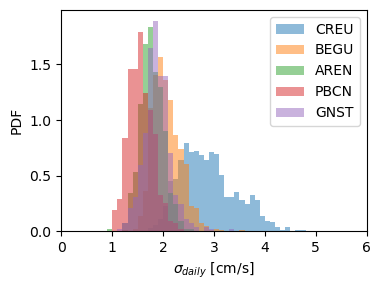

In [17]:
fig, ax = plt.subplots(figsize=(width, height))

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data

    # plot

    ax.hist(sigma, label=site, bins=150, range=[0, 15], 
             alpha=0.5, density=True, color=hfrcolors[site])

ax.legend()
ax.set_xlim(0, 6)
ax.set_xlabel('$\\sigma_{daily}$ [cm/s]')
ax.set_ylabel('PDF')
fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure4.pdf')

**Figure 4**. PDF of $\sigma_{daily}$ for the five HFR stations analyzed. Vertical dashed line corresponds to the estimation of noise obtained using the fitting method for the network AREN-PBCN-GNST and the dotted line the noise obtained with the same method for the network CREU-BEGU.

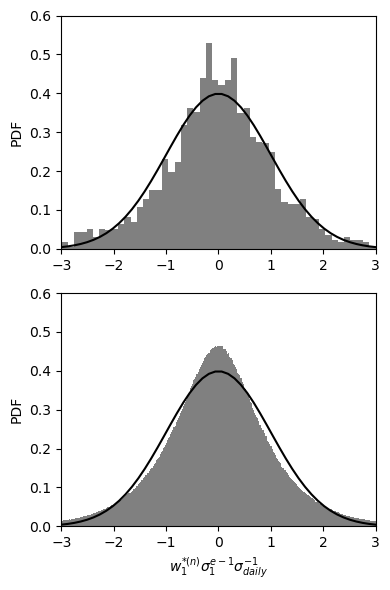

In [18]:
# Parameters

orientation = 'v'
station = example_stat
i = iexample

# Create the plot

if orientation == 'h':
    fig, ax = plt.subplots(1, 2, figsize=(width * 2, height))
else:
    fig, ax = plt.subplots(2, 1, figsize=(width, 2 * height))

x = np.linspace(-3, 3)
pdf = np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)

for j, a in enumerate(ax.flatten()):
    
    if j == 0:

        nobs = hfrdata_daily[station]['nobs'][i, :, :].data   # Read the data
        w1 = hfrdata_daily[station]['w1'][i, :, :].data
        sigma = hfrdata_daily[station]['sigma'][i].data
        data = w1[nobs >= 1] / sigma
        
        nbins = 50

    elif j == 1:

        data = data=np.zeros(0)
        for key in hfrdata_daily.keys():
            nobs = hfrdata_daily[key]['nobs'].data   # Read the data
            w1 = hfrdata_daily[key]['w1'].data
            sigma = hfrdata_daily[key]['sigma'].data
            w1 = w1 / sigma[:, np.newaxis, np.newaxis] # Normalize 
            data = np.append(data, w1[nobs >= 1])

        nbins = 300

    a.hist(data, bins=nbins, range=[-3, 3], density=True, color='gray')
    a.plot(x, pdf, color='k')

for j, a in enumerate(ax):
    a.set_xlim(-3, 3)
    a.set_ylim(0, 0.6)
    if (orientation == 'h' and j == 0) or orientation != 'h':
        a.set_ylabel('PDF')
    if (orientation != 'h' and j == 1) or orientation == 'h':
        a.set_xlabel('$w_1^{*(n)} \\sigma_1^{e-1} \\sigma_{daily}^{-1}$')

fig.tight_layout()
fig.savefig('figures/figure5.pdf')

**Figure 5**. Probability Density Functions (PDF) for the corrected noisy wavelet coefficients for the example shown in Figure 3 (top) and for the whole time series (bottom). Coefficients are normalized by the noise standard deviation. The solid line corresponds to a Normal distribution with unit variance.

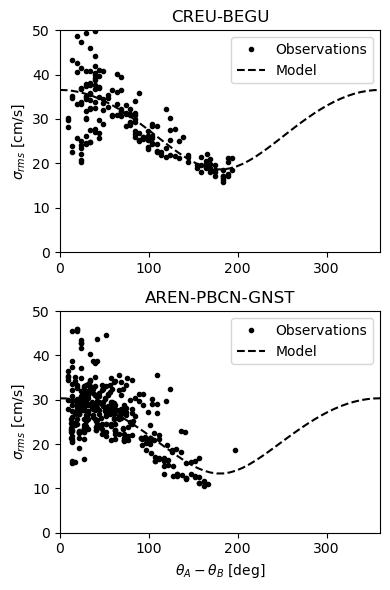

In [19]:
nplots = len(hfrnetworks.keys())

fig, ax = plt.subplots(nplots, 1, figsize=(width, height * nplots))
for i, name in enumerate(hfrnetworks.keys()):
    
    angle = np.abs(hfrnetworks[name]['angle'])
    rmse = hfrnetworks[name]['rmse']
    stdu = hfrnetworks[name]['stdu']
    stde = hfrnetworks[name]['stde']

    ax[i].plot(angle, rmse, 'k.', label='Observations')
    
    angle = np.linspace(0, 360)
    ax[i].plot(angle, hfr_rmse_model(angle, stdu, stde), 'k--', label='Model')

    ax[i].set_title(name)
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0, 50)
    ax[i].set_ylabel('$\\sigma_{rms}$ [cm/s]')
    if i == nplots-1:
        ax[i].set_xlabel('$\\theta_A-\\theta_B$ [deg]')
    ax[i].legend()

fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure6.pdf')

**Figure 6** Observed RMSE $\sigma_{rms}$ at crossover points for the two subnetworks with the fitted model of RMSE.

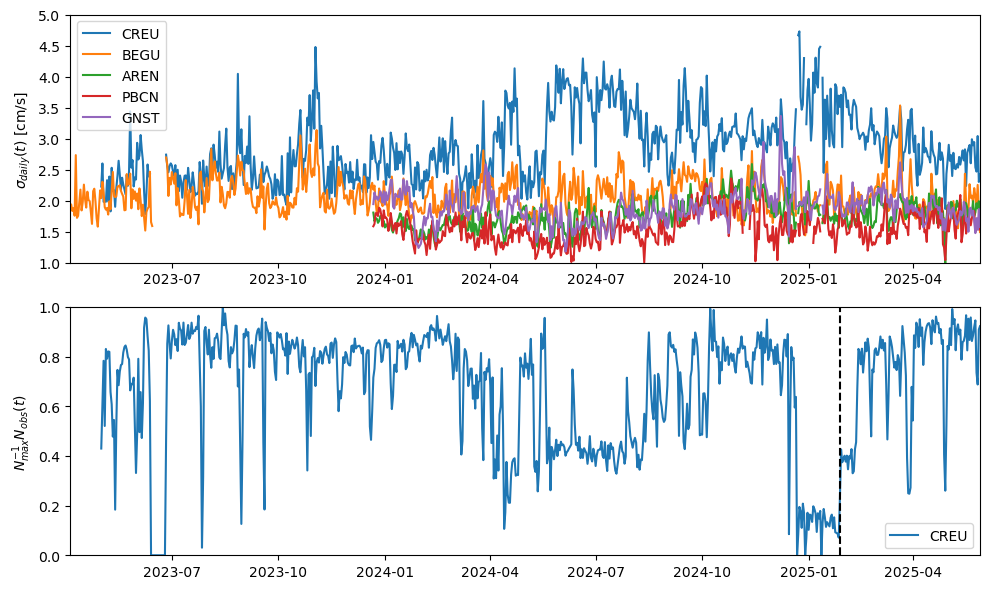

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 2 * height))

tmin = []
tmax = []

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data
    time = hfrdata_daily[site]['time'].data

    nobs = np.sum(hfrdata_daily[site]['nobs'].data, axis=(1, 2))

    tmin.append(np.min(time))
    tmax.append(np.max(time))
    
    # Plot

    ax[0].plot(time, sigma, color=hfrcolors[site], label=site)

    if site == 'CREU':
        ax[1].plot(time, nobs/np.max(nobs), color=hfrcolors[site], label=site)

tmin = np.min(np.array(tmin))
tmax = np.max(np.array(tmax))

ax[0].legend()
ax[0].set_ylabel('$\\sigma_{daily}(t)$ [cm/s]')
ax[0].set_ylim(1, 5)
ax[0].set_xlim(tmin, tmax)

ax[1].legend()
ax[1].set_ylabel('$N_{max}^{-1}N_{obs}(t)$')
ax[1].set_xlim(tmin, tmax)
#ax[1].axvspan(np.datetime64("2024-06-01"), np.datetime64("2025-01-28"), color='r', alpha=0.1)
ax[1].axvline(np.datetime64("2025-01-28"), color='k',linestyle='--')
ax[1].set_ylim(0, 1)

fig.tight_layout()
fig.savefig(figspath + os.sep + 'figure7.pdf')

**Figure 7**. Time evolution of the noise level (top) and number of observations divided by its observed maximum for the CREU station (bottom). The dashed line in the bottom plot corresponds to the date of the antenna repair (January 28 2025).

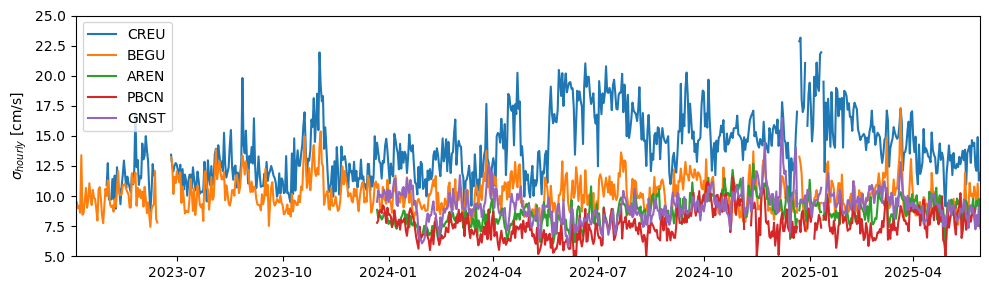

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, height))

tmin = []
tmax = []

for site in hfrsites:

    # Get the data
    
    sigma = hfrdata_daily[site]['sigma'].data
    time = hfrdata_daily[site]['time'].data

    tmin.append(np.min(time))
    tmax.append(np.max(time))
    
    # Plot

    ax.plot(time, np.sqrt(24) * sigma, color=hfrcolors[site], label=site)

tmin = np.min(np.array(tmin))
tmax = np.max(np.array(tmax))

ax.legend()
ax.set_ylabel('$\\sigma_{hourly}$ [cm/s]')
ax.set_ylim(5, 25)
ax.set_xlim(tmin, tmax)

fig.tight_layout()
#fig.savefig('figures/fig_noise_time_series.pdf')